In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from scipy import integrate

import sys
sys.path.append('../../scripts/')
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18)

In [2]:
# Data
methods = ['tejaas_rr', 'tejaas_jpa', 'matrixeqtl']
ntfs = [50, 100, 150]
tfscales = [10, 15, 20]

data = dict()
errdata = dict()

for method in methods:
    data[method] = dict()
    errdata[method] = dict()
    for ntf in ntfs:
        data[method][ntf] = dict()
        errdata[method][ntf] = dict()
        for tfscale in tfscales:
            if method == 'tejaas_rr': 
                data[method][ntf][tfscale] = np.random.random() * 0.3 + 0.7
            elif method == 'tejaas_jpa':
                rfact = np.random.random() * 0.1 + 0.6
                data[method][ntf][tfscale] = data['tejaas_rr'][ntf][tfscale] * rfact
            elif method == 'matrixeqtl':
                rfact = np.random.random() * 0.1 + 0.7
                data[method][ntf][tfscale] = data['tejaas_rr'][ntf][tfscale] * rfact
            errdata[method][ntf][tfscale] = np.random.random() * 0.05 + 0.075

In [3]:
# Data
methods = ['tejaas_rr', 'tejaas_jpa', 'matrixeqtl']
ntfs = [50, 100, 150]
tfscales = [10, 15, 20]
srcdir = '/scratch/sbanerj/trans-eqtl/simulation'

data  = dict()
errup = dict()
errdn = dict()

for method in methods:
    data[method]  = dict()
    errup[method] = dict()
    errdn[method] = dict()
    for ntf in ntfs:
        data[method][ntf]  = dict()
        errup[method][ntf] = dict()
        errdn[method][ntf] = dict()
        for tfscale in tfscales:
            simdir = "15158_450_20_800_30_{:d}_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_{:d}_0.02".format(ntf, tfscale)
            if method == 'tejaas_rr':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/rr_fpr_tpr.txt')
            elif method == 'tejaas_jpa':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/jpa_fpr_tpr.txt')
            elif method == 'matrixeqtl':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/matrixeqtl_fpr_tpr.txt')
                if not os.path.exists(rocfile):
                    rocfile = os.path.join(srcdir, simdir, 'rocdata/jpa_fpr_tpr.txt')
            roc = np.loadtxt(rocfile, skiprows=1)
            auc = integrate.simps(roc[:, 1], roc[:, 0])
            aucup = integrate.simps(roc[:, 1] + roc[:, 2], roc[:, 0])
            aucdown = integrate.simps(roc[:, 1] - roc[:, 2], roc[:, 0])
            data[method][ntf][tfscale]  = auc
            errup[method][ntf][tfscale] = aucup
            errdn[method][ntf][tfscale] = aucdown

In [4]:
def single_barplot(ax, yvals, ymax, yerr, methodcolors, errcolors, ymajorticks, yminorticks, yshift,
                   xlabel, ylabel, showyaxis, showxlabel, showerror):
    
    nbar = len(yvals)

    ax.set_yticks([y - yshift for y in ymajorticks])
    ax.set_yticks([y - yshift for y in yminorticks], minor=True)
    ax.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False, labelbottom = False)
    ax.grid(which = 'minor', axis = 'y', linestyle = 'dotted', zorder = 0)
    
    ind = np.arange(1, nbar + 1)
    ax.bar(ind, [y - yshift for y in yvals], color = methodcolors, linewidth = 0, width = 0.8, zorder = 10)
    
    # Errorbars done separately. The one included in bar() method mess up the zorder
    if showerror:
        for i in range(nbar):
            errmin = yvals[i] - yerr[i] - yshift
            errmax = yvals[i] + yerr[i] - yshift
            ax.plot([ind[i], ind[i]], [errmin, errmax], color = errcolors[i], zorder = 20)

    
    if showyaxis: 
        ax.tick_params(which = 'major', right = True, labelright = True)
        yticks = ax.get_yticks(minor = False)
        yticklabels = ['{:2.1f}'.format(y + yshift) for y in yticks]
        ax.set_yticklabels(yticklabels, minor = False)
        ax.set_ylabel(ylabel)
        ax.yaxis.set_label_position("right")
        
    if showxlabel:
        ax.set_xlabel(xlabel)
        
    for side, border in ax.spines.items():
        if not side == 'bottom':
            border.set_visible(False)
        if showyaxis and side == 'right':
            border.set_visible(True)

    ax.set_ylim([-0.05, ymax - yshift])
    ax.set_xlim([0, nbar + 1])
    ax.set_facecolor('None')
    
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent + 0.5 * (width - height)
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

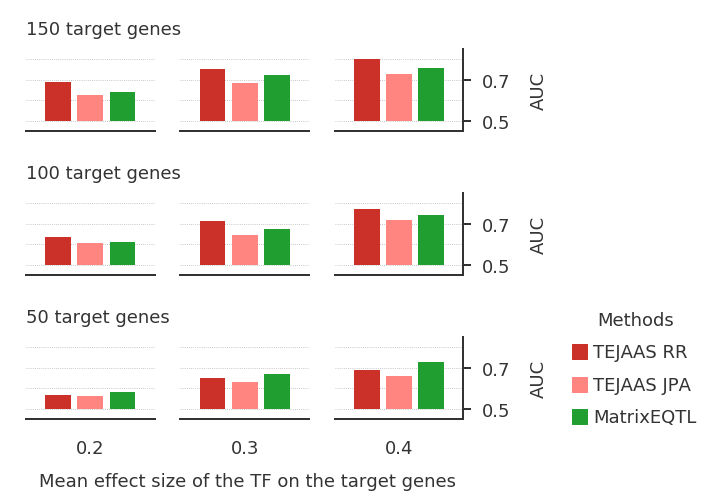

In [21]:
nrow = max([len(vals) for m, vals in data.items()])
ncol = max([len(val2) for m, val1 in data.items() for ntf, val2 in val1.items()])

rownames = [None for x in range(nrow)]
colnames = [None for x in range(ncol)]
yvals = [dict() for x in range(nrow * ncol)]
yerrs = [dict() for x in range(nrow * ncol)]

methodcolors = {'tejaas_rr':  '#cc3129ff',
                'tejaas_jpa': '#ff8680ff',
                'matrixeqtl': '#209E2FFF',
                'matrixeqtl_fdr': '#1fcc80ff'}

methodlabels = {'tejaas_rr': 'TEJAAS RR', 
                'tejaas_jpa': 'TEJAAS JPA',
                'matrixeqtl': 'MatrixEQTL'}

for method in methods:
    methodvals = data[method]
    for irow, ntfvals in enumerate(methodvals.items()):
        rownames[irow] = ntfvals[0]
        for icol, values in enumerate(ntfvals[1].items()):
            colnames[icol] = values[0] * 0.02
            index = irow * ncol + icol
            yvals[index][method] = values[1]
            yerrs[index][method] = errup[method][ntfvals[0]][values[0]] - errdn[method][ntfvals[0]][values[0]]
            
fig = plt.figure(figsize = (7.5, 6))
bgcolor = 'white'
#bgcolor = 'cornsilk'
ymax = 0.85
yshift = 0.5
ymajorticks = [0.5, 0.7, 0.9]
yminorticks = [0.5, 0.6, 0.7, 0.8, 0.9]
ylabel = 'AUC'
mcolors = [methodcolors[x] for x in methods]
ecolors = ['#333333' for x in methods]
showerror = False

gs = [None for x in range(nrow)]
ax = [None for x in range(nrow * ncol)]

hspacefrac = 0.1
bottompos = [i * (1 / nrow) for i in range(nrow)]
toppos = [bottompos[i] + ( (1 - hspacefrac) / nrow) for i in range(nrow)]

for irow in range(nrow):
    rowtext =  '{:d} target genes'.format(rownames[irow])
    bg_gs = gridspec.GridSpec(1, 1, figure = fig, left = 0, right = 1,
                              bottom = bottompos[irow], top = toppos[irow],
                              hspace = 0, wspace = 0)
    bg_ax = fig.add_subplot(bg_gs[0])
    bg_ax.set_facecolor(bgcolor)
    for side, border in bg_ax.spines.items():
        border.set_visible(False)
    bg_ax.tick_params(bottom = False, top = False, left = False, right = False, 
                   labelleft = False, labelbottom = False)
    bg_ax.text(0.02, 0.85, rowtext)
    if irow == 0:
        bg_ax.set_xlabel('Mean effect size of the TF on the target genes', labelpad = 40, x = 0.43)
    
    gs[irow] = gridspec.GridSpec(1, ncol, figure = fig, 
                                 left = 0.02, right = 0.83, 
                                 bottom = bottompos[irow] + 0.03, top = toppos[irow] - 0.08, 
                                 wspace = 0.2)
    showxlabel = False
    if irow == 0: showxlabel = True
    for icol in range(ncol):
        xlabel = '{:g}'.format(colnames[icol])
        showyaxis = False
        idx = irow * ncol + icol
        ax[idx] = fig.add_subplot(gs[irow][icol])
        y = [val for key, val in yvals[idx].items()]
        yerr = [val for key, val in yerrs[idx].items()]
        if icol == ncol - 1: showyaxis = True
        single_barplot(ax[idx], y, ymax, yerr, mcolors, ecolors, 
                       ymajorticks, yminorticks, yshift,
                       xlabel, ylabel, showyaxis, showxlabel, showerror)
        
legendtitle = 'Methods'
mhandles = [mpatches.Rectangle((0,0), 20, 20, **{'color': methodcolors[x]}) for x in methods]
mlabels = [methodlabels[x] for x in methods]
mhandler_map = dict()
for x in mhandles:
    mhandler_map[x] = HandlerSquare()
legend = ax[2].legend(handles = mhandles, labels = mlabels, handler_map = mhandler_map,
                      loc = 'lower left', bbox_to_anchor = (1.8, -0.2), frameon = True, title = legendtitle)
lframe = legend.get_frame()
#lframe.set_facecolor(bgcolor)
lframe.set_linewidth(0)

#plt.savefig('../plots/auc_comparison_tfmag_gtex_ms_correlation.png', bbox_inches='tight')
plt.show()